# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [2]:
rect_start = None
rect_end = None
drawing = False

In [3]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [4]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display

    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [6]:
coord = interactive_bbox_selection("test_image.jpg")

Coordinates: [142, 133, 3445, 5973]


### Segment image based on rectangle coordinates


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\test_image.jpg: 640x640 1 0, 4251.6ms
Speed: 7.5ms preprocess, 4251.6ms inference, 80.9ms postprocess per image at shape (1, 3, 640, 640)


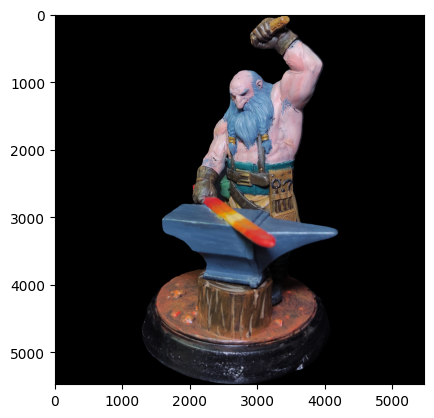

In [9]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [11]:
def segmenting_image(coordinates, model, conf = 0.4, iou = 0.4):
    results = model(source,
                    device="cpu",
                    retina_masks=True,
                    imgsz=640,
                    conf=conf,
                    iou=iou,
                    bboxes=coordinates)

    for result in results:
        img = np.copy(result.orig_img)

        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)

            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

            isolated = img.copy()
            isolated[b_mask == 0] = 0

            contour = contour.reshape(-1, 2)

            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)

            # Crop the image to get only the segmented
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

            # Make the image square and centralize the segmented image
            height, width, _ = resultado_rgb.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 3), dtype=np.uint8)

            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2

            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

            plt.imshow(square_image)

### Combining everything

Coordinates: [230, 196, 3386, 6020]

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\test_image.jpg: 640x640 1 0, 4311.7ms
Speed: 161.4ms preprocess, 4311.7ms inference, 81.6ms postprocess per image at shape (1, 3, 640, 640)


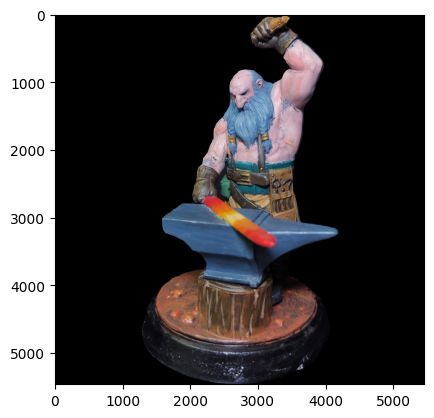

In [12]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

rect_start = None
rect_end = None
drawing = False

source = "test_image.jpg"
model = SAM("models/sam_l.pt")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, 0.2, 0.2)

## 3D reconstruction from videos

### Installing COLMAP and PyCOLMAP

In [ ]:
%git clone https://github.com/microsoft/vcpkg
%cd vcpkg
%.\bootstrap-vcpkg.bat
%.\vcpkg install colmap[cuda,tests]:x64-windows

### Extract Frames from Video

In [1]:
import cv2
import os

def extract_frames(video_path, output_folder, resize_width=640, frame_interval=10):
    """Extracts frames from a video and resizes them."""
    os.makedirs(output_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame while maintaining aspect ratio
        height, width = frame.shape[:2]
        aspect_ratio = height / width
        new_height = int(resize_width * aspect_ratio)
        resized_frame = cv2.resize(frame, (resize_width, new_height))
        
        # Save frame
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.jpg")
            cv2.imwrite(frame_filename, resized_frame)
            extracted_count += 1
        
        frame_count += 1 

    cap.release()
    print(f"Extracted {frame_count} resized frames to {output_folder}")

# Example usage:
extract_frames("test_video.mp4", "frames")

Extracted 1560 resized frames to frames


### Run Feature Extraction and Matching in PyCOLMAP

In [1]:
import pycolmap
import os

def run_colmap_pipeline(image_dir, output_dir):
    """Runs the full COLMAP pipeline (sparse + dense reconstruction) on CPU."""
    os.makedirs(output_dir, exist_ok=True)
    sparse_dir = os.path.join(output_dir, "sparse/0")
    dense_dir = os.path.join(output_dir, "dense")
    database_path = os.path.join(output_dir, "database.db")

    # Run sparse reconstruction only once
    if not os.path.exists(os.path.join(sparse_dir, "images.bin")):
        print("Running sparse reconstruction...")
        pycolmap.extract_features(database_path=database_path, image_path=image_dir)
        pycolmap.match_sequential(database_path=database_path)
        pycolmap.incremental_mapping(database_path=database_path, 
                                     image_path=image_dir, 
                                     output_path=sparse_dir)

    # Undistort images using the single sparse reconstruction
    print("Undistorting images...")
    os.makedirs(dense_dir, exist_ok=True)
    pycolmap.undistort_images(output_path=dense_dir, 
                              input_path=sparse_dir, 
                              image_path=image_dir)

    # Perform dense reconstruction (Multi-View Stereo)
    print("Running dense reconstruction on CPU...")
    pycolmap.patch_match_stereo(dense_dir, use_gpu=False)
    pycolmap.stereo_fusion(dense_dir, output_path=os.path.join(dense_dir, "fused.ply"))

    print(f"Dense reconstruction completed! 3D model saved at: {os.path.join(dense_dir, "fused.ply")}")
    return os.path.join(dense_dir, "fused.ply")

# Example usage:
reconstruction = run_colmap_pipeline("frames", "colmap_output")

Undistorting images...
Running dense reconstruction on CPU...


AttributeError: module 'pycolmap' has no attribute 'patch_match_stereo'

### Convert the Reconstruction to a 3D Model

In [ ]:
import open3d as o3d
import numpy as np

def visualize_point_cloud(ply_path):
    """Loads and visualizes the 3D point cloud using Open3D."""
    pcd = o3d.io.read_point_cloud(ply_path)
    o3d.visualization.draw_geometries([pcd])

# Visualize the reconstructed point cloud
visualize_point_cloud(reconstruction)